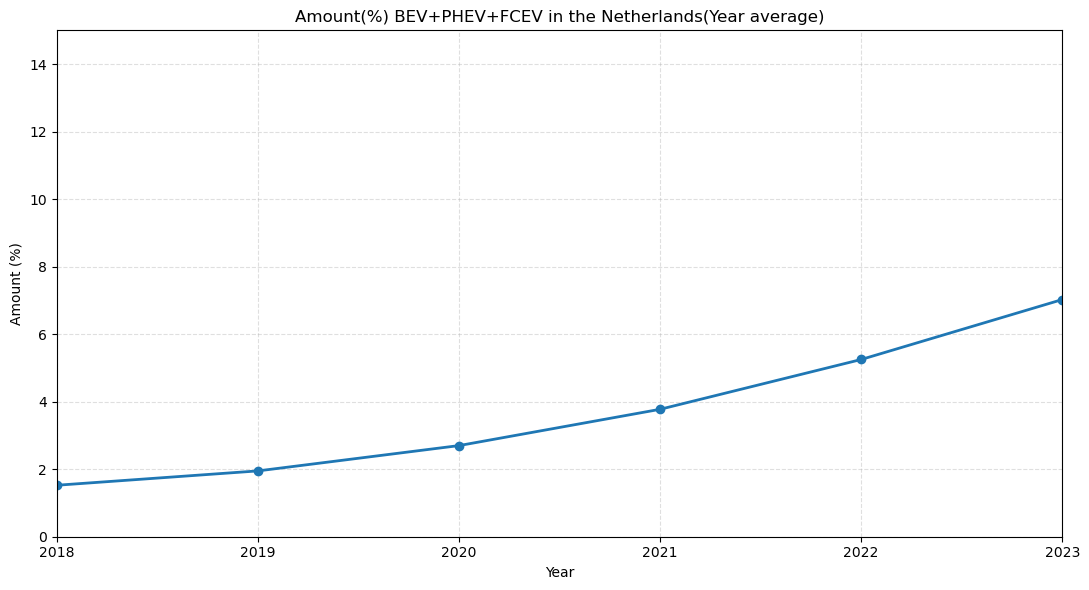

In [4]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- Pad naar jouw CSV (pas aan indien nodig)
CSV_PATH = Path("Procentuele aandeel BEV_ FCEV en PHEV personenauto's in het wagenpark.csv")

def load_yearly_means(path: Path) -> pd.DataFrame:
    
    df = pd.read_csv(path, sep=";", engine="python", encoding="utf-8-sig")

    # Gebruik de eerste datarij als labels voor kolommen 1..n (BEV, FCEV, PHEV)
    new_cols = list(df.columns)
    first_row = df.iloc[0].tolist()
    new_cols[0] = "Datum"
    for i in range(1, len(new_cols)):
        lab = first_row[i]
        if isinstance(lab, str) and lab.strip():
            new_cols[i] = lab.strip()
    df.columns = new_cols

    # Verwijder de 'kop-rij' die we net als labels gebruikten
    df = df.iloc[1:].reset_index(drop=True)

    # Jaar uit Nederlandse datums als "31 maart 2018"
    def parse_year(s: str):
        m = re.search(r"(\d{4})", str(s))
        return int(m.group(1)) if m else np.nan

    df["jaar"] = df["Datum"].apply(parse_year).astype("Int64")
    df = df[df["jaar"].notna()].copy()
    df["jaar"] = df["jaar"].astype(int)

    # "1,2%" -> 1.2  |  "0.012" (fracties) -> 1.2
    def to_pct_keep(x):
        raw = str(x)
        s = raw.strip().replace(",", ".").replace("%", "")
        try:
            val = float(s)
        except Exception:
            return np.nan
        if "%" in raw:          # reeds in procenten
            return val
        return val * 100.0 if val <= 1.0 else val

    for col in ["BEV", "FCEV", "PHEV"]:
        if col in df.columns:
            df[col] = df[col].apply(to_pct_keep)

    # Aggregeer naar JAAR (gemiddelde over kwartalen)
    ts = (df.groupby("jaar", as_index=False)[["BEV", "FCEV", "PHEV"]]
            .mean(numeric_only=True)
            .sort_values("jaar"))
    return ts

def main():
    ts = load_yearly_means(CSV_PATH)
    ts["BEV+PHEV+FCEV"] = ts[["BEV", "PHEV", "FCEV"]].sum(axis=1)

    # Plot: één lijn, y-as 0–20%
    plt.figure(figsize=(11, 6))
    plt.plot(ts["jaar"], ts["BEV+PHEV+FCEV"], marker="o", linewidth=2)
    plt.title("Amount(%) BEV+PHEV+FCEV in the Netherlands(Year average)")
    plt.xlabel("Year")
    plt.ylabel("Amount (%)")
    plt.xlim(2018, 2023)
    plt.ylim(0, 15)           # <- bovengrens 20%
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()



if __name__ == "__main__":
    main()
